In [305]:
import pandas as pd
import numpy as np

data_red = pd.read_csv("winequality-red.csv",header = None)
data_white = pd.read_csv("winequality-white.csv",header = None)
red = pd.DataFrame(np.array([1]*data_red.shape[0]))
white = pd.DataFrame(np.array([0]*data_white.shape[0]))



data_red, data_white = pd.concat([data_red,red],axis = 1),pd.concat([data_white,white],axis = 1)
data_red.columns = data_white.columns = ["fixed acidity",
                                         "volatile acidity",
                                         "citric acid",
                                         "residual sugar",
                                         "chlorides",
                                         "free sulfur dioxide",
                                         "total sulfur dioxide",
                                         "density",
                                         "pH",
                                         "sulphates",
                                         "alcohol",
                                         "quality",
                                         "wine type"]

data = pd.concat([data_red,data_white],axis = 0)

In [306]:
X,y = data.iloc[:,:-1],data.iloc[:,-1]

The dataset has imbalanced classes, the ratio of class 0 to class 1 is 3:1. Therefore, we first need to balance these classes by upsampling class 1.

In [307]:
from sklearn.utils import resample
X_upsampled, y_upsampled = resample(X[y==1],
                                   y[y==1],
                                   n_samples = X[y==0].shape[0],
                                   replace = True,
                                   random_state = 123)
X_bal = np.vstack((X[y==0],X_upsampled))
y_bal = np.hstack((y[y==0],y_upsampled))
print(X_bal[y_bal ==0].shape, X_bal[y_bal ==1].shape)

(4898, 12) (4898, 12)


Scaling the dataset

In [308]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X_bal)

First we use Logistic regression model for prediction

In [309]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc,y_bal,test_size = 0.1, random_state = 1)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 10, solver = "liblinear",multi_class = "auto")
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)
y_pred = lr.predict(X_test)

Plotting the ROC (Receiver Operating Characterstic) curve and Precision-Recall curve for model evaluation

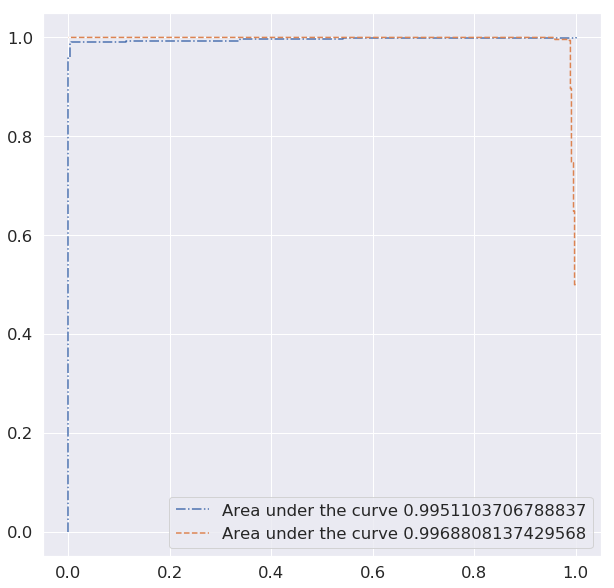

In [310]:
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve
from sklearn.metrics import auc,precision_score, roc_auc_score

fig, axes = plt.subplots(figsize = (10,10))

fpr, tpr, threshold = roc_curve(y_test,y_prob[:,1])
precision, recall, threshold = precision_recall_curve(y_test, y_prob[:,1])

plt.plot(fpr,tpr,label = "Area under the curve {}".format(auc(fpr,tpr)),ls = "-.")
plt.plot(recall, precision,label = "Area under the curve {}".format(auc(recall,precision)),ls = "--")
plt.legend(loc = "best")
plt.show()

Creating a clustering model and plotting the silhouette plot

In [352]:
def plotSilhouetteSamples(X,Y,n_clusters = 3):
    import numpy as np
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples
    from sklearn.cluster import DBSCAN
    
    #Performing a LDA on the training set
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    lda = LDA(n_components=2)
    lda.fit(X,Y)
    X_lda = lda.transform(X)
    
    km = KMeans(n_clusters=n_clusters,
           init = "k-means++",
           n_init = 10,
           max_iter = 300,
           tol = 1e-04,
           random_state = 0)
    y = km.fit_predict(X_lda)
    
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X_lda,y, 
                                         metric = "euclidean")
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()

        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                 c_silhouette_vals,
                 height=1.0,
                 edgecolor='none',
                 color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)

    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()
    return y


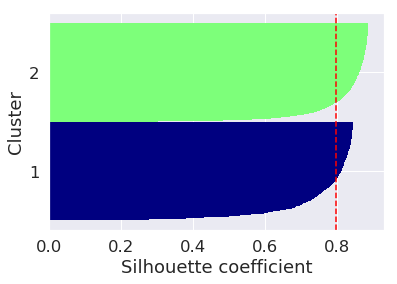

In [359]:
y_cluster_pred = plotSilhouetteSamples(X_train,y_train, n_clusters=2)